<a href="https://colab.research.google.com/github/gracelin0711/20250218/blob/main/%E7%A8%8B%E5%BC%8F%E4%BD%9C%E6%A5%AD2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 問題定義

* **目標**：根據鑽石的各項特徵（如 carat、cut、color、clarity、x、y、z 等）預測其價格等級（High / Medium / Low）。
* **任務類型**：多類別監督式分類。
* **核心模型**：**K‑Nearest Neighbors (KNN)**。
* **評估指標**：主要使用 **Accuracy**，輔以 Precision、Recall、F1、混淆矩陣。

## 資料收集

| 來源                   |  特徵數  | 樣本數 | 類別 |
| -------------------- | ----- | --- | -- |
| seaborn 內建 diamonds |  7  | 53,940 | 3（High, Medium, Low 價格等級）  |

In [ ]:
import seaborn as sns
df = sns.load_dataset("diamonds")


## 資料前處理

### 資料清理

In [ ]:
import pandas as pd

# 建立價格等級：Low（<2400）、Medium（2400~6500）、High（>6500）
df["price_level"] = pd.cut(df["price"], bins=[0, 2400, 6500, float("inf")],
                           labels=["Low", "Medium", "High"])
print(df.isna().any().any())

False


In [ ]:
import seaborn as sns
import pandas as pd

df = sns.load_dataset("diamonds")

# 檢查整體有沒有缺失值
print(df.isna().sum())


carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64


原始資料無缺失，可直接進行後續處理。

### 探索性分析

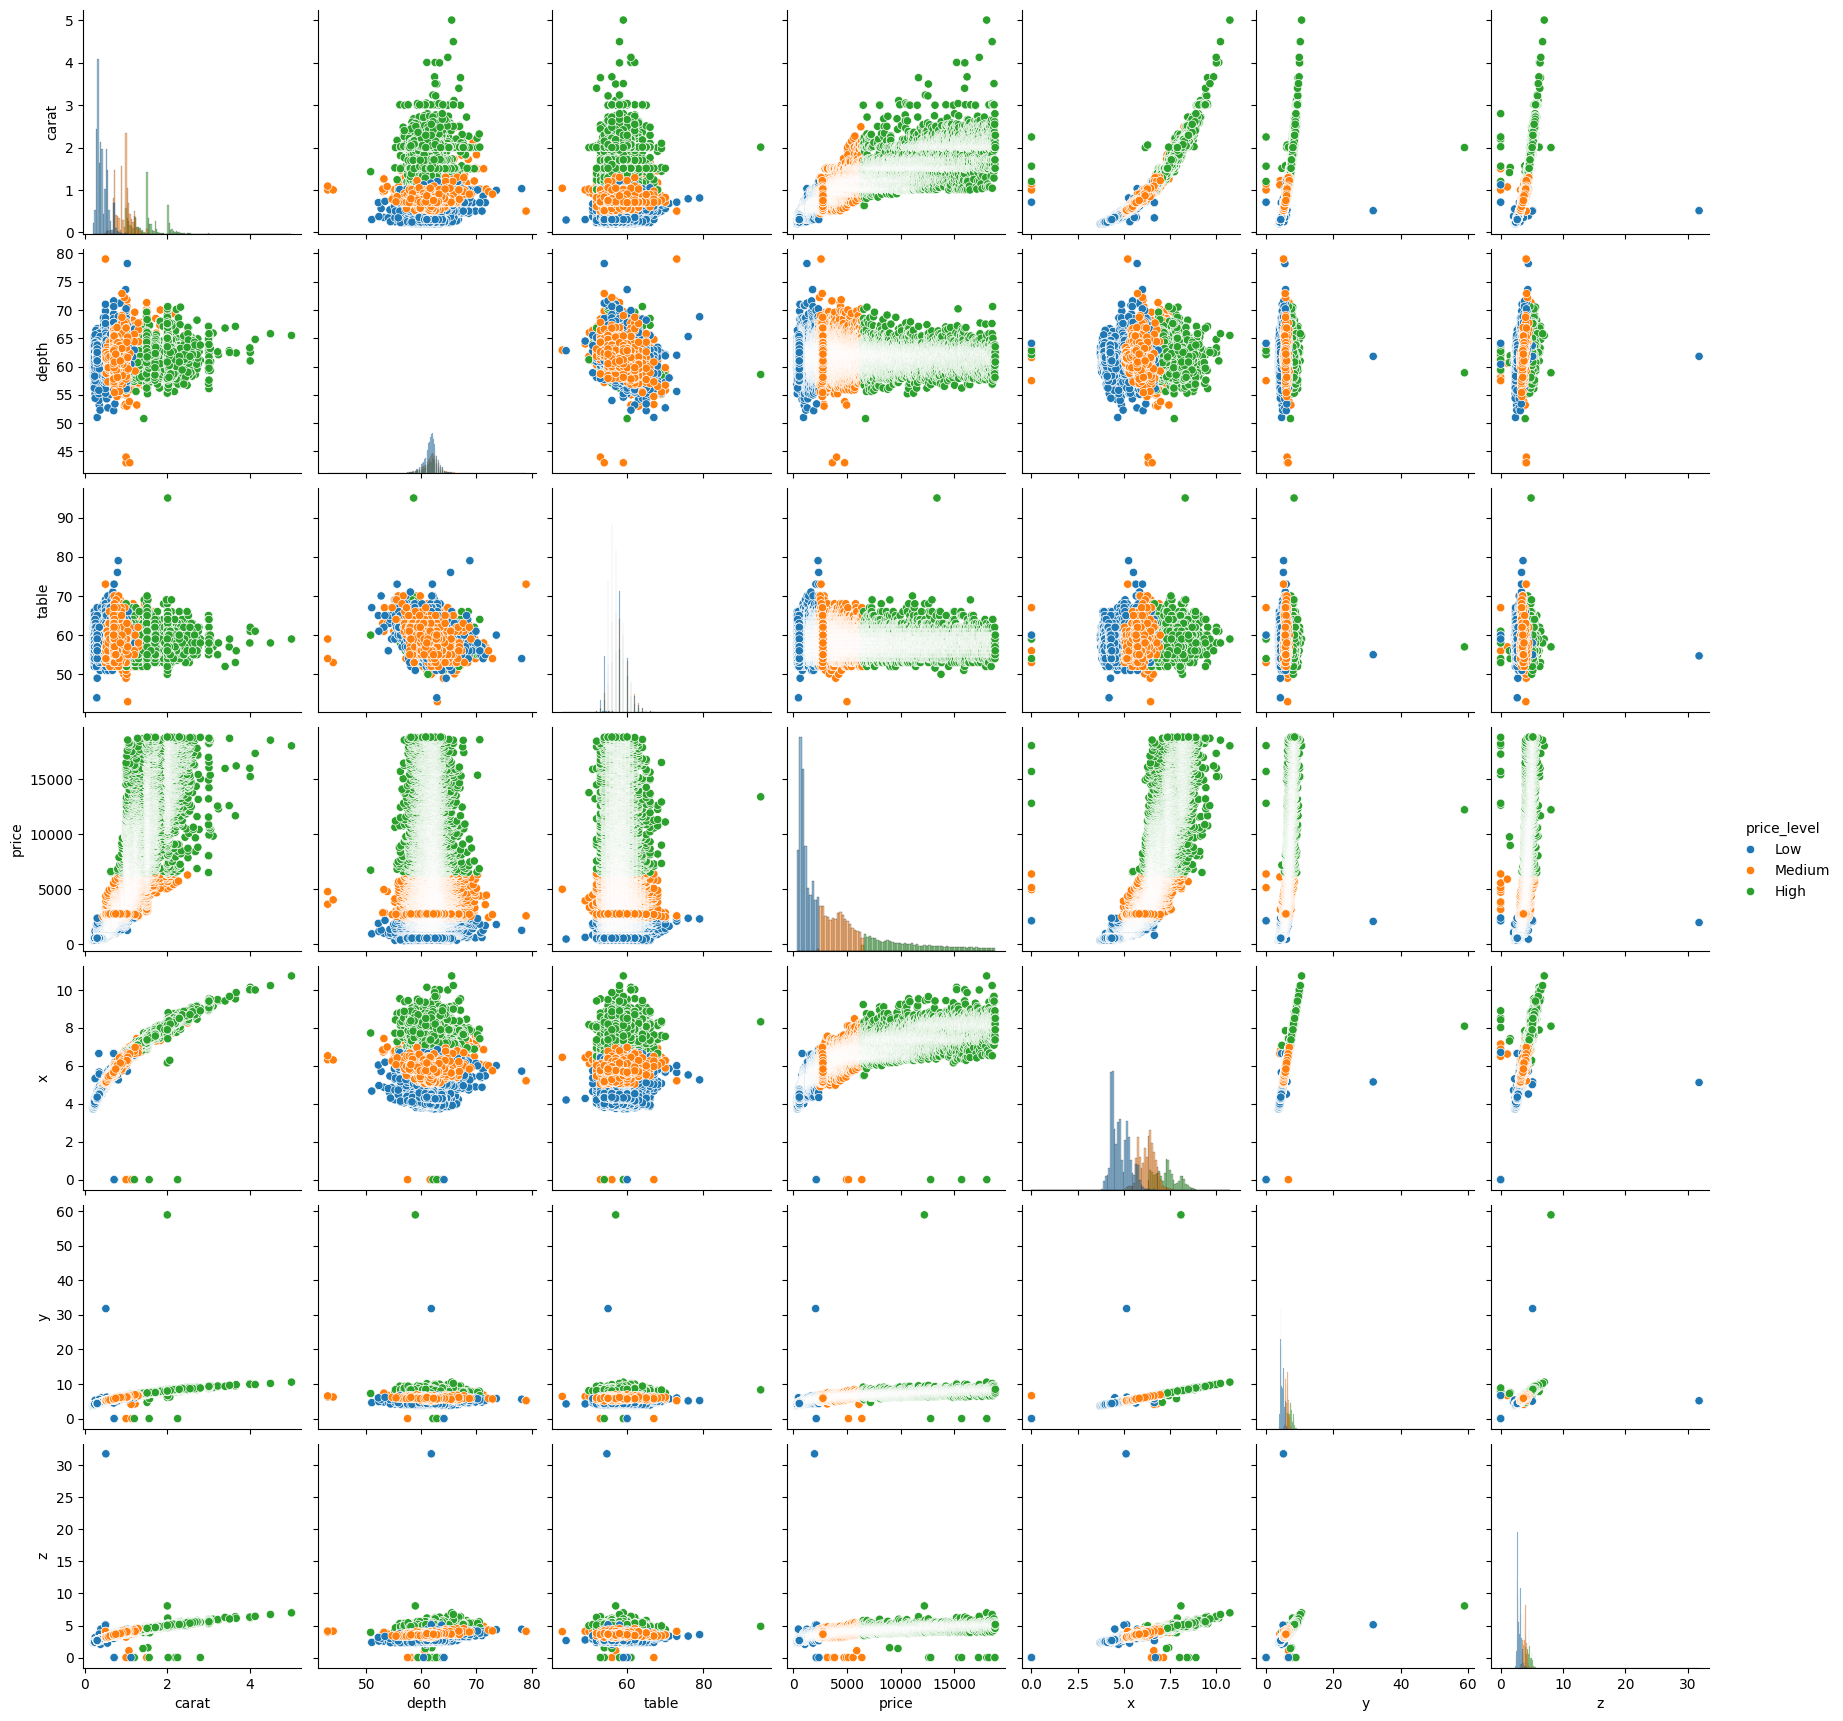

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(df[["carat", "depth", "table", "price", "x", "y", "z", "price_level"]],
             hue="price_level", diag_kind="hist")
plt.show()




*  carat 與 x、y、z 尺寸與價格等級高度相關。在圖中，High 等級的鑽石（綠色）通常集中在 carat 高（右上區域）及x, y, z 尺寸大（右偏上方區域），這說明尺寸越大，價格越高，因此這些變數對分類任務有強區分力。

*  depth 和 table 對價格等級的區分度不高。在圖中三種價格等級的點分布比較混亂、重疊，表示這些特徵與 price_level 相關性較低，可考慮不要納入模型。






<Axes: xlabel='cut', ylabel='price'>

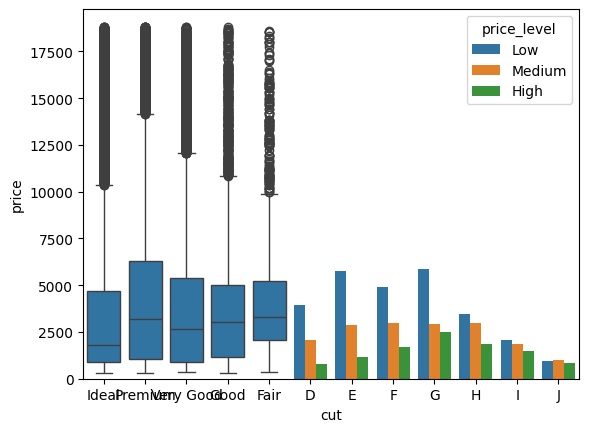

In [ ]:
sns.boxplot(data=df, x='cut', y='price')
sns.countplot(data=df, x='color', hue='price_level')


*  cut 好壞與價格有一定相關，但沒那麼強

*  color 分布也與價格等級有明顯不同，可考慮後續納入模型並進行 one-hot 編碼。


### 資料分割

In [ ]:
from sklearn.model_selection import train_test_split

features = df[["carat", "x", "y", "z"]]
target = df["price_level"]

X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, stratify=target, random_state=42
)


### 特徵縮放

由於 KNN 演算法基於距離計算，若特徵量級差異過大，將影響預測結果，因此須進行標準化處理（Standardization）。

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


## 模型訓練

採用 KNN 演算法訓練模型。

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline

knn_clf = make_pipeline(
    StandardScaler(),
    KNeighborsClassifier(n_neighbors=5, weights="uniform", metric="euclidean")
)

knn_clf.fit(X_train, y_train)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsclassifier',
                 KNeighborsClassifier(metric='euclidean'))])

## 模型評估

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred = knn_clf.predict(X_test)
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Test Accuracy: 0.863

Classification Report:
              precision    recall  f1-score   support

        High       0.80      0.74      0.77      2066
         Low       0.95      0.94      0.95      5392
      Medium       0.76      0.81      0.78      3330

    accuracy                           0.86     10788
   macro avg       0.84      0.83      0.83     10788
weighted avg       0.86      0.86      0.86     10788

Confusion Matrix:
[[1529    1  536]
 [   2 5093  297]
 [ 373  272 2685]]


整體準確率（Test Accuracy）：0.863，表示模型在測試資料上有穩定且不錯的預測表現。

各類別預測表現：

   Low 價格等級

    Precision：0.95、Recall：0.94，F1-score 高達 0.95。

    幾乎所有低價鑽石皆被正確識別，顯示特徵（如 carat, x, y, z）與價格的線性關係清晰。

  Medium 價格等級

    Recall：0.81，F1-score：0.78，略高於 High 類別。

    混淆矩陣顯示有約 272 筆被錯判為 Low，373 筆錯為 High，代表 Medium 類特徵與其他類有一定重疊。

  High 價格等級

    Recall：0.74，F1-score：0.77，為三類中最低。

    約 26% 的 High 被誤分類為 Medium（536 筆），可見特徵仍難完全區分高價品。

Macro 平均指標：

  Precision: 0.84、Recall: 0.83、F1-score: 0.83，表現均衡，代表各類別的預測能力平均。

Weighted 平均指標：

  加權後 F1-score：0.86，與整體 Accuracy 一致，代表類別不平衡問題處理得當。

## 模型調整

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import uniform, randint # 導入 randint 處理整數參數

pipe = make_pipeline(StandardScaler(), KNeighborsClassifier())

# 更新 param_dist 以匹配 KNeighborsClassifier 的參數名稱和類型
param_dist = {
    "kneighborsclassifier__n_neighbors": randint(1, 21), # 使用 randint 處理整數範圍
    "kneighborsclassifier__weights": ["uniform", "distance"],
    "kneighborsclassifier__metric": ["euclidean", "manhattan"]
    # 移除了與 LogisticRegression 相關的參數
}

random_search = RandomizedSearchCV(pipe, param_distributions=param_dist,
                                   n_iter=10, cv=3, scoring="accuracy", n_jobs=-1)
random_search.fit(X_train, y_train) # X_train 和 y_train 應該是之前定義的訓練資料
print("最佳參數：", random_search.best_params_)

最佳參數： {'kneighborsclassifier__metric': 'manhattan', 'kneighborsclassifier__n_neighbors': 20, 'kneighborsclassifier__weights': 'uniform'}


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

pipe = make_pipeline(StandardScaler(), KNeighborsClassifier())

param_grid = {
    "kneighborsclassifier__n_neighbors": range(1, 21),
    "kneighborsclassifier__weights": ["uniform", "distance"],
    "kneighborsclassifier__metric": ["euclidean", "manhattan"]
}

grid = GridSearchCV(pipe, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid.fit(X_train, y_train)

print("最佳參數：", grid.best_params_)
print("CV 平均 Accuracy：", grid.best_score_)
best_model = grid.best_estimator_ # 確保在這裡分配 best_model，並執行此儲存格

最佳參數： {'kneighborsclassifier__metric': 'euclidean', 'kneighborsclassifier__n_neighbors': 19, 'kneighborsclassifier__weights': 'uniform'}
CV 平均 Accuracy： 0.8740497382511745



- GridSearchCV：全面搜尋所有參數組合，適合參數空間不大時使用。
- RandomizedSearchCV：隨機抽樣部分參數組合，搜尋速度較快，適合初期粗略篩選或參數範圍較廣時。


## 模型部署

### 儲存模型

In [ ]:
import joblib

joblib.dump({
    "pipeline": best_model,
    "label_encoder": target.cat.categories.tolist()
}, "diamond_price_knn.joblib")


['diamond_price_knn.joblib']

### 推論預測

In [ ]:
# 預測範例
sample = [[0.9, 6.2, 6.3, 3.9]]  # carat, x, y, z
artifacts = joblib.load("diamond_price_knn.joblib")
pipe = artifacts["pipeline"]
pred = pipe.predict(sample)[0]
print("預測價格等級：", pred)

預測價格等級： Medium


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


## 結論

使用 KNN 模型（初始設定 k=5、euclidean 距離）搭配特徵標準化處理後，可在 diamonds 資料集上獲得不錯的價格等級預測表現。經由 RandomizedSearchCV 及 GridSearchCV 調參後，準確率可進一步提升。後續可考慮整合更多類別型特徵（如 cut、color、clarity）進行 one-hot 編碼，提升模型效果。

## 未來展望

本專案採用 K-Nearest Neighbors (KNN) 模型，並透過特徵標準化與超參數調整，成功預測鑽石的價格等級。在僅使用連續型尺寸特徵的情況下，模型已展現良好表現。後續可考慮：

- 納入類別型變數（如 cut, color, clarity）並進行 one-hot 編碼，以豐富模型輸入資訊。
- 嘗試其他分類模型（如 Random Forest、SVM、XGBoost），比較其在此任務上的表現。
- 分析模型錯誤案例，以進一步精進特徵選擇與資料處理策略。
